# Transfert Learning ResNet 50

In [104]:
pip install opencv-python

In [1]:
import tensorflow as tf
import keras
from keras import Model
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
# Early stopping & checkpointing the best model in
#../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Initialisation de l'architecture  
ResNet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling="avg"
)


In [3]:
NUMB_CLASSES = 2
DENSE_LAYER_ACTIVATION = 'softmax'
# Transfert Learning 
model = tf.keras.Sequential()
model.add(ResNet_50)
model.add(Dense(NUMB_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.layers[0].trainable = False

In [4]:
# Optimizer sgd il y a aussi adam ..
sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
OBJECTIVE_FUNCTION = 'categorical_crossentropy' # loss il y a ausi mean_squared_error ...
LOSS_METRICS = ['accuracy']

model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [5]:
# Prepare Keras Data Generators
from keras.applications.resnet50 import preprocess_input

image_size = 224
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        'C:/Users/lenovo/Desktop/DONNEES/DATA/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'C:/Users/lenovo/Desktop/DONNEES/DATA/validation',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 3629 images belonging to 2 classes.
Found 1555 images belonging to 2 classes.


In [6]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 37, 100, 16)

In [7]:
EARLY_STOP_PATIENCE = 3

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'C:/Users/lenovo/Desktop/DONNEES/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [8]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 247s 25s/step - loss: 0.7712 - accuracy: 0.7072 - val_loss: 0.3232 - val_accuracy: 0.8570
Epoch 2/10
10/10 [==============================] - 274s 27s/step - loss: 0.3051 - accuracy: 0.8750 - val_loss: 0.2268 - val_accuracy: 0.9040
Epoch 3/10
10/10 [==============================] - 328s 33s/step - loss: 0.2184 - accuracy: 0.9090 - val_loss: 0.2150 - val_accuracy: 0.9180
Epoch 4/10
10/10 [==============================] - 338s 34s/step - loss: 0.2030 - accuracy: 0.9180 - val_loss: 0.1696 - val_accuracy: 0.9370
Epoch 5/10
10/10 [==============================] - 303s 30s/step - loss: 0.1828 - accuracy: 0.9310 - val_loss: 0.1739 - val_accuracy: 0.9360
Epoch 6/10
10/10 [==============================] - 288s 29s/step - loss: 0.1393 - accuracy: 0.9520 - val_loss: 0.1821 - val_accuracy: 0.9270
Epoch 7/10
10/10 [==============================] - 307s 31s/step - loss

In [9]:
model.load_weights("C:/Users/lenovo/Desktop/DONNEES/best.hdf5")

In [10]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


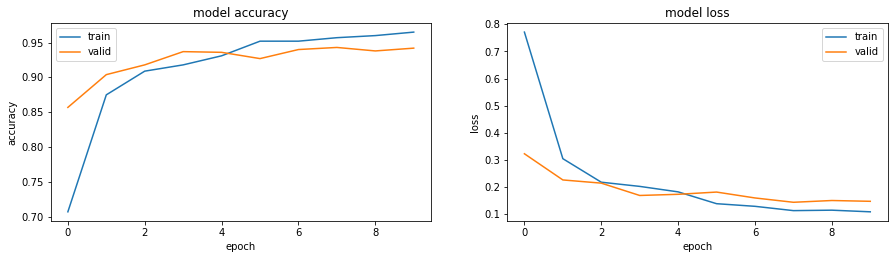

In [11]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [12]:
BATCH_SIZE_TESTING = 1

test_generator = data_generator.flow_from_directory(
    directory = 'C:/Users/lenovo/Desktop/DONNEES/DATA/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 2222 images belonging to 2 classes.


In [13]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
2222/2222 [==============================] - 488s 220ms/step


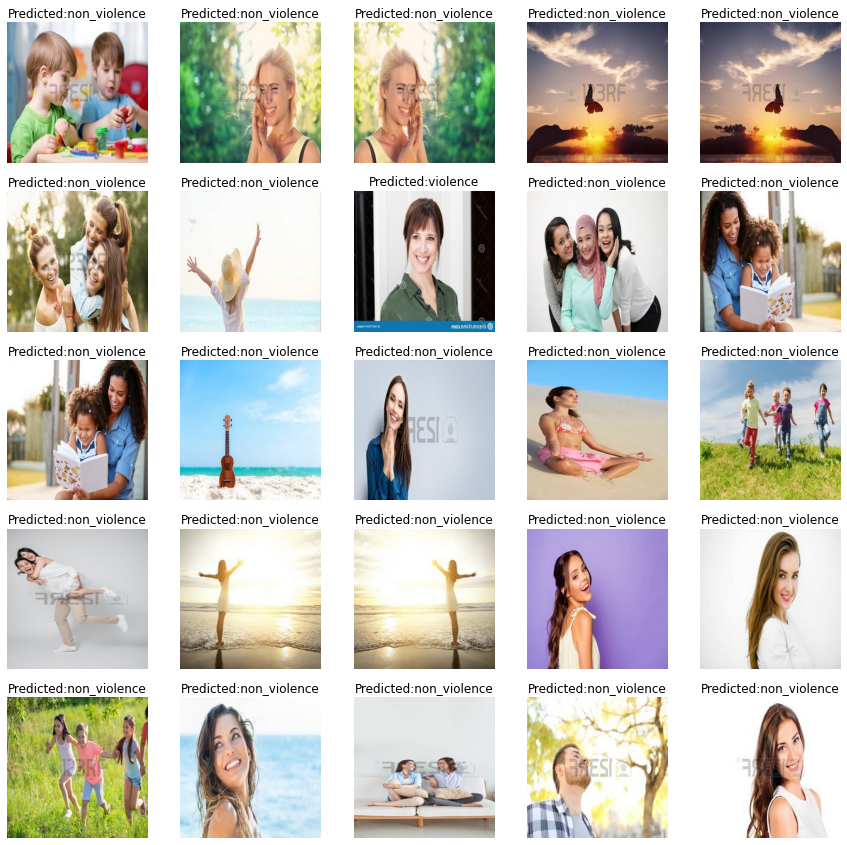

In [23]:
TEST_DIR = 'C:/Users/lenovo/Desktop/DONNEES/DATA/test'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR +"/"+ test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "violence" if predicted_class_indices[i] else "non_violence"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()


In [27]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('C:/Users/lenovo/Desktop/DONNEES/Pred_results_ResNet50.csv', index=False)
results_df


,id,label
1113,1,1
981,6,0
1051,8,0
1114,10,0
173,15,0
...,...,...
2006,3693,1
909,3693,0
910,3695,0
912,3706,0
